In [106]:
import math
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

**Getting meteorological data**

In [136]:
def parse_meteo(station_idx, filename, start_year=2000, end_year=2019, verbose = False):
    '''
    This function parse meteorological data from Meteomanz.com site
    '''
    month = {'01': '31', '02': '28', '03': '31', '04': '30', '05': '31', '06': '30', '07': '31', '08': '31', '09': '30', '10': '31', '11': '30', '12': '31'}
    data = pd.DataFrame(columns = ['date', 't_avg', 't_max', 't_min', 'prec', 'pres', 'w_dir', 'w_sp', 'c_ind', 'sn_d'])
    row_marker = 0
    for y in range(start_year, end_year):
        for m in month.keys():
            params = {'l':1, 'cou': 6310, 'ind': station_idx, 'd1': '01', 'm1': m, 'y1': y, 'd2': month.get(m), 'm2': m, 'y2': y}
            req = requests.get('http://www.meteomanz.com/sy2', params = params)
            soup = BeautifulSoup(req.content, 'html.parser')
            tab = soup.find_all('table')[0]
            for row in tab.find_all('tr'):
                column_marker = 0
                columns = row.find_all('td')
                for column in columns:
                    data.at[row_marker,data.columns[column_marker]] = column.get_text()
                    column_marker += 1
                row_marker += 1
            print(str(y) + ' ' + m + ' data processed')
    data.to_csv(filename, index=False)
    if verbose:print('data processing finished')

In [135]:
parse_meteo(34047, 'zherdevka.csv', 2013, 2019)

2013 01 data processed
2013 02 data processed
2013 03 data processed
2013 04 data processed
2013 05 data processed
2013 06 data processed
2013 07 data processed
2013 08 data processed
2013 09 data processed
2013 10 data processed
2013 11 data processed
2013 12 data processed
2014 01 data processed
2014 02 data processed
2014 03 data processed
2014 04 data processed
2014 05 data processed
2014 06 data processed
2014 07 data processed
2014 08 data processed
2014 09 data processed
2014 10 data processed
2014 11 data processed
2014 12 data processed
2015 01 data processed
2015 02 data processed
2015 03 data processed
2015 04 data processed
2015 05 data processed
2015 06 data processed
2015 07 data processed
2015 08 data processed
2015 09 data processed
2015 10 data processed
2015 11 data processed
2015 12 data processed
2016 01 data processed
2016 02 data processed
2016 03 data processed
2016 04 data processed
2016 05 data processed
2016 06 data processed
2016 07 data processed
2016 08 dat

**Train LSTM model for weather forecast**

In [57]:
data = pd.read_csv('borisoglebsk.csv', parse_dates=True)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by = 'date')
data = data.reset_index(drop=True)

In [58]:
data.head()

,date,t_avg,t_max,t_min,prec,pres,w_dir,w_sp,c_ind,sn_d
0,2013-01-01,-3.5,-0.8,-6.1,-,1018.2 Hpa,256º(W),5,7/8,1
1,2013-01-02,-4.4,0.2,-9.0,-,1006.0 Hpa,196º(S),5,7/8,11
2,2013-01-03,2.5,3.8,1.2,-,1000.6 Hpa,271º(W),11,7/8,1
3,2013-01-04,8.4,14.7,2.2,-,1017.4 Hpa,168º(S),11,4/8,NaN
4,2013-01-05,20.6,26.5,14.8,-,1020.6 Hpa,177º(S),8,6/8,NaN


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [63]:
dataset = data[['t_avg']]

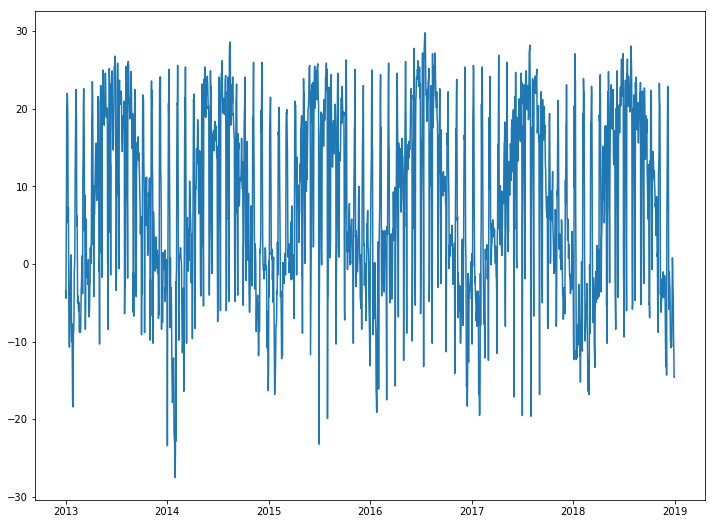

In [62]:
plt.rcParams["figure.figsize"] = (12, 9)
plt.plot(data['date'], data['t_avg'])

In [94]:
# split into train and test sets
dataset = dataset.values
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

1642 548


In [95]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [96]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [99]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [103]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
 - 9s - loss: 157.4235
Epoch 2/30
 - 8s - loss: 112.4286
Epoch 3/30
 - 8s - loss: 83.6636
Epoch 4/30
 - 9s - loss: 67.6974
Epoch 5/30
 - 8s - loss: 58.7926
Epoch 6/30
 - 8s - loss: 53.7468
Epoch 7/30
 - 8s - loss: 50.6685
Epoch 8/30
 - 8s - loss: 48.9344
Epoch 9/30
 - 8s - loss: 47.8375
Epoch 10/30
 - 8s - loss: 47.1274
Epoch 11/30
 - 8s - loss: 46.4801
Epoch 12/30
 - 8s - loss: 46.3220
Epoch 13/30
 - 9s - loss: 45.9678
Epoch 14/30
 - 8s - loss: 45.5633
Epoch 15/30
 - 8s - loss: 45.3834
Epoch 16/30
 - 8s - loss: 45.0200
Epoch 17/30
 - 8s - loss: 45.0320
Epoch 18/30
 - 9s - loss: 45.0388
Epoch 19/30
 - 9s - loss: 44.8493
Epoch 20/30
 - 8s - loss: 44.9004
Epoch 21/30
 - 8s - loss: 44.7153
Epoch 22/30
 - 8s - loss: 44.5752
Epoch 23/30
 - 8s - loss: 44.5772
Epoch 24/30
 - 8s - loss: 44.3563
Epoch 25/30
 - 8s - loss: 44.5536
Epoch 26/30
 - 8s - loss: 44.4156
Epoch 27/30
 - 8s - loss: 44.0959
Epoch 28/30
 - 8s - loss: 44.2425
Epoch 29/30
 - 8s - loss: 44.1026
Epoch 30/30
 - 8s - l

In [112]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.61 RMSE
Test Score: 6.63 RMSE


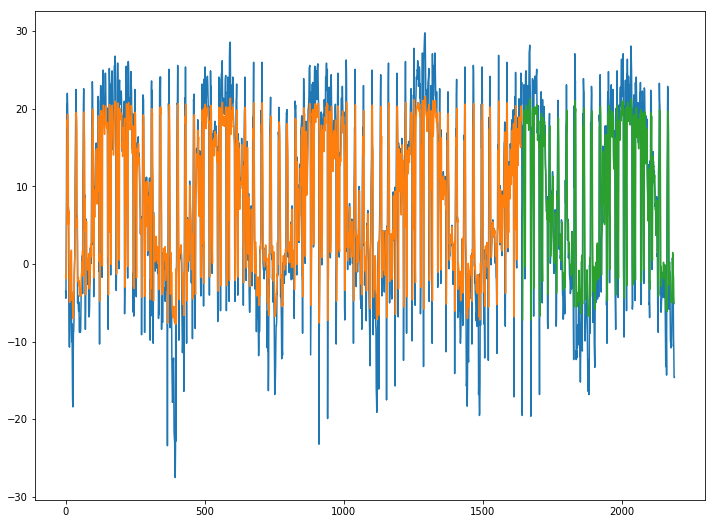

In [115]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()